In [4]:
pip install seaborn

     |████████████████████████████████| 292 kB 14.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import math
import dlib
import sys
from scipy.spatial import distance
from facenet_pytorch import MTCNN, InceptionResnetV1
from PIL import Image, ImageDraw
sys.path.append("/work/Particle_Filter/circle_finder_main/circle_finder_main")
from circle_finder.csf import CircularSeparabilityFilter
from circle_finder.torch import EllipticalSeparabilityFilter
sys.path.append("/work/Particle_Filter")
from particle_fileter_main.test_1 import ParticleFilter
from contour_extraction.test_0 import clac_contour_iris
from contour_extraction.test_1 import Contour_Iris
from imutils import face_utils
import time
#楕円形分離度フィルタ
def a(img,a,b,c,d):
    axes_in = a,b
    axes_out = c,d
    angle = 0
    esf = EllipticalSeparabilityFilter(axes_in,axes_out,angle)
    epmap,circles = esf.find_circles(img, num_circles=5)   #num_circlesの適切値は？？
    cut_img = esf.cut_img_4(img,circles)     #カットできない画像は黒画像が返される
    rgb = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    return epmap,cut_img,circles
#中心座標を用いて、指定サイズにトリミング
def cut_img(img,center,size):
    x = int(size[0]/2)
    y = int(size[1]/2)
    a= int(center[0])
    b= int(center[1])
    data = img[b-y:b+y,a-x:a+x]
    return data
#開眼度の計算1
def calc_ear(eye):
    A = distance.euclidean(eye[1], eye[5])
    B = distance.euclidean(eye[2], eye[4])
    C = distance.euclidean(eye[0], eye[3])
    eye_ear = (A + B) / (2.0 * C)
    return round(eye_ear, 3)
#開眼度の計算2
def calc_ratio(im_gray,radius):
    iris_outline = np.argwhere(im_gray==255)
    x = iris_outline[:,1]
    x = np.unique(x)
    length_max = 0
    for i in x:
        try:
            y_index = np.argwhere(iris_outline[:,1] == i)
            y = iris_outline[y_index,0]
            y_mean = np.mean(y)
            y_up = np.max(y[y<y_mean])
            y_down = np.min(y[y>y_mean])
            length = y_down-y_up
            if length_max < length:
                length_max = length
            #print(f"i:{i}の時 , length_max/(radius*2):{length_max/(radius*2)}")
        except ValueError as e:
            #print(f"radius:{round(radius,3)}, {x[0]}から{x[-1]+1}の横軸において:{i}, Error：{e}")
            pass
    return round(length_max/(radius*2), 3)

#虹彩の中心座標と虹彩半径の計算
def eye_center(eye):
    A = (eye[1]+eye[4])
    B = (eye[2]+eye[5])
    position = (A + B) / 4
    C = distance.euclidean(eye[1],eye[4])
    D = distance.euclidean(eye[2],eye[5])
    radius = (C + D ) / 4   #目をつぶったとき分離度マップはどうなる？？
    return position,radius
#右目ランドマークのプロット
def plot_landmark(numpy_img,landmark):
    for index,(x,y) in enumerate(landmark,start=36):
        x = landmark[index][0]
        y = landmark[index][1]
        if(index==42):break
        else:cv.circle(numpy_img, (x, y), 5, (255, 255, 0), -1)
    return numpy_img
#トリミングするサイズの計算
def calc_size(eye):
    A = distance.euclidean(eye[0], eye[3])*2
    B = distance.euclidean(eye[1], eye[4])
    C = distance.euclidean(eye[2], eye[5])
    D = (B + C)
    size = (int(A),int(D))
    return size

In [2]:
def tracking():
    start = time.time()
    #初期設定
    path = "/work/Particle_Filter/Siamese_Network/video/Bright_40cm.mp4"
    cap = cv.VideoCapture(path)
    size = (1080,1920) #元画像のサイズ
    filter_eye_left = ParticleFilter(size)
    filter_eye_left.initialize() #パーティクルフィルタ初期化    
    x,y,z = 0,0,0
    flag = True
    img_left,img_right,img_3,img_4,img_5,img_6,img_7,eye_left_opening_rate = [],[],[],[],[],[],[],[]
    alpha,beta = 0,0
    threshold = 0   #得たいフレームの開始番号    
    face_detector = dlib.get_frontal_face_detector()    # 顔検出ツールの呼び出し
    predictor_path = '/work/Particle_Filter/particle_fileter_main/shape_predictor_68_face_landmarks.dat'
    face_predictor = dlib.shape_predictor(predictor_path)
    #各フレームに対して虹彩の輪郭を求める
    while flag:
        if x<threshold:
            ret, img_1 = cap.read()
            x+=1
        if x>threshold or x ==threshold:
            ret, img_1 = cap.read()   
            if x%50==0:
                print(str(x)+"枚目の画像の追跡")
#             print(str(x)+"枚目の画像の追跡") 
            x+=1
            #ランドマークの抽出
            if(cap.isOpened()==True and img_1 is not None):#Trueが返されたら動画読み込みOK
                test_img = img_1.copy()#引数用
                draw_img = img_1.copy()#描画用
                img_gry = cv.cvtColor(test_img, cv.COLOR_BGR2GRAY)
                faces = face_detector(img_gry, 1)
                for face in faces:#検出した顔の数だけfor文を回す
                    landmark = face_predictor(img_gry, face)
                    landmark = face_utils.shape_to_np(landmark)# 処理高速化のためランドマーク群をNumPy配列に変換(必須)     
                    center,radius = eye_center(landmark[36:42])#虹彩の中心と分離度フィルタの半径を得る
                    size = calc_size(landmark[36:42]) #ここでトリミングするサイズが決まる！！
                    width,height =  size[0],size[1]
                    x_before,y_before = size[0]/2,size[1]/2
                    #draw_img =  plot_landmark(draw_img,landmark)#左目のランドマークをplot
                    #print(f"size:{size}/radius:{radius}/center:{center}/")
            else:
                x+=1
                continue
            #ランドマークの判別処理
            if (landmark is not None):
                center_eye_left = center[0],center[1]#全体の状態での座標
                center_eye_left_x,center_eye_left_y = center[0],center[1]
            else:
                center_eye_left = [center_eye_left_x,center_eye_left_y]#radius,sizeは1フレーム前のものを採用する
            #虹彩の中心座標を求める
            img_eye_left = cut_img(img_1,center_eye_left,size)#左の瞳付近をトリミング
            y_after, x_after = filter_eye_left.filtering(img_eye_left, radius, width,height)#瞳の中心座標の推定値を取得
            #全体画像に対して虹彩の中心座標をプロット
            alpha = x_after - x_before
            beta = y_after - y_before
            center_eye_left_x_1 = center_eye_left_x+alpha
            center_eye_left_y_1 = center_eye_left_y+beta
            cv.circle(draw_img,center=(int(center_eye_left_x_1), int(center_eye_left_y_1)),radius=3,color=(0, 0, 255),thickness=-1)
            #虹彩輪郭の抽出
            center_eye_left_1 = center_eye_left_x_1,center_eye_left_y_1#全体の状態での座標
            img_eye_left = cut_img(test_img,center_eye_left_1,size)
            img_eye_left =  cv.cvtColor(img_eye_left, cv.COLOR_BGR2RGB)
            contour_iris = Contour_Iris(img_eye_left,radius)
            point_list = contour_iris() 
            #トリミングした画像に対して輪郭抽出
            im_gray = cv.cvtColor(img_eye_left, cv.COLOR_RGB2GRAY)
            for i in range(len(point_list[0])):
                cv.circle(img_eye_left, center=(int(point_list[1][i]),int(point_list[0][i])),radius=1,color=(255,255,255),thickness=1)
                cv.circle(im_gray, center=(int(point_list[1][i]),int(point_list[0][i])),radius=1,color=(255,255,255),thickness=1)
            ratio = calc_ratio(im_gray,radius)#開眼度推定
            #全体画像に対して虹彩の輪郭をプロット
            for i in range(len(point_list[0])):
                alpha = point_list[1][i] - x_before
                beta = point_list[0][i] - y_before
                outline_x = center_eye_left_x_1+alpha
                outline_y = center_eye_left_y_1+beta
                cv.circle(draw_img, center=(int(outline_x),int(outline_y)),radius=1,color=(255, 255, 255),thickness=1)
            draw_img =  cv.cvtColor(draw_img, cv.COLOR_BGR2RGB)
            #"""
                        
            #出力準備
            img_3.append(draw_img)
            img_4.append(img_eye_left)
            #img_5.append(binary)
            img_6.append(radius)
            img_7.append(test_img)
            eye_left_opening_rate.append(ratio)
            
        if x > 600:#目を閉じた後しっかり追跡できるか
            elapsed_time = time.time() - start
            print (f"elapsed_time:{round(elapsed_time,3)}[sec]")
            print("追跡を終了します")
            flag = False
    return img_3 , img_4 , img_6 , img_7 , eye_left_opening_rate

In [3]:
img,img_2,radius,origin,ratio = tracking()

0枚目の画像の追跡
50枚目の画像の追跡
100枚目の画像の追跡
150枚目の画像の追跡
200枚目の画像の追跡
250枚目の画像の追跡
300枚目の画像の追跡
350枚目の画像の追跡
400枚目の画像の追跡
450枚目の画像の追跡
500枚目の画像の追跡
550枚目の画像の追跡
600枚目の画像の追跡
elapsed_time:1042.824[sec]
追跡を終了します


ratio:0.674 , radius:21.50293024581861


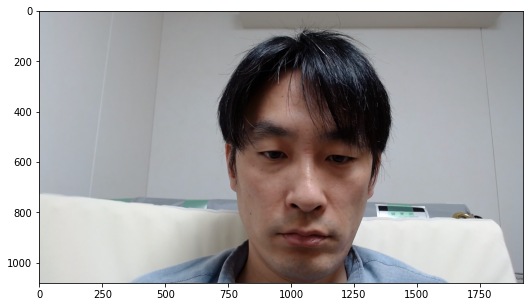

In [4]:
x=100
plt.figure(figsize=(10,5))
print(f"ratio:{ratio[x]} , radius:{radius[x]}")
ori = cv.cvtColor(origin[x], cv.COLOR_BGR2RGB)
plt.imshow(ori)

radius[17]:11.088607452238751 , ratio[17]:0.09
追跡元画像サイズ：(1080, 1920, 3)
虹彩周辺画像サイズ：(44, 116, 3)


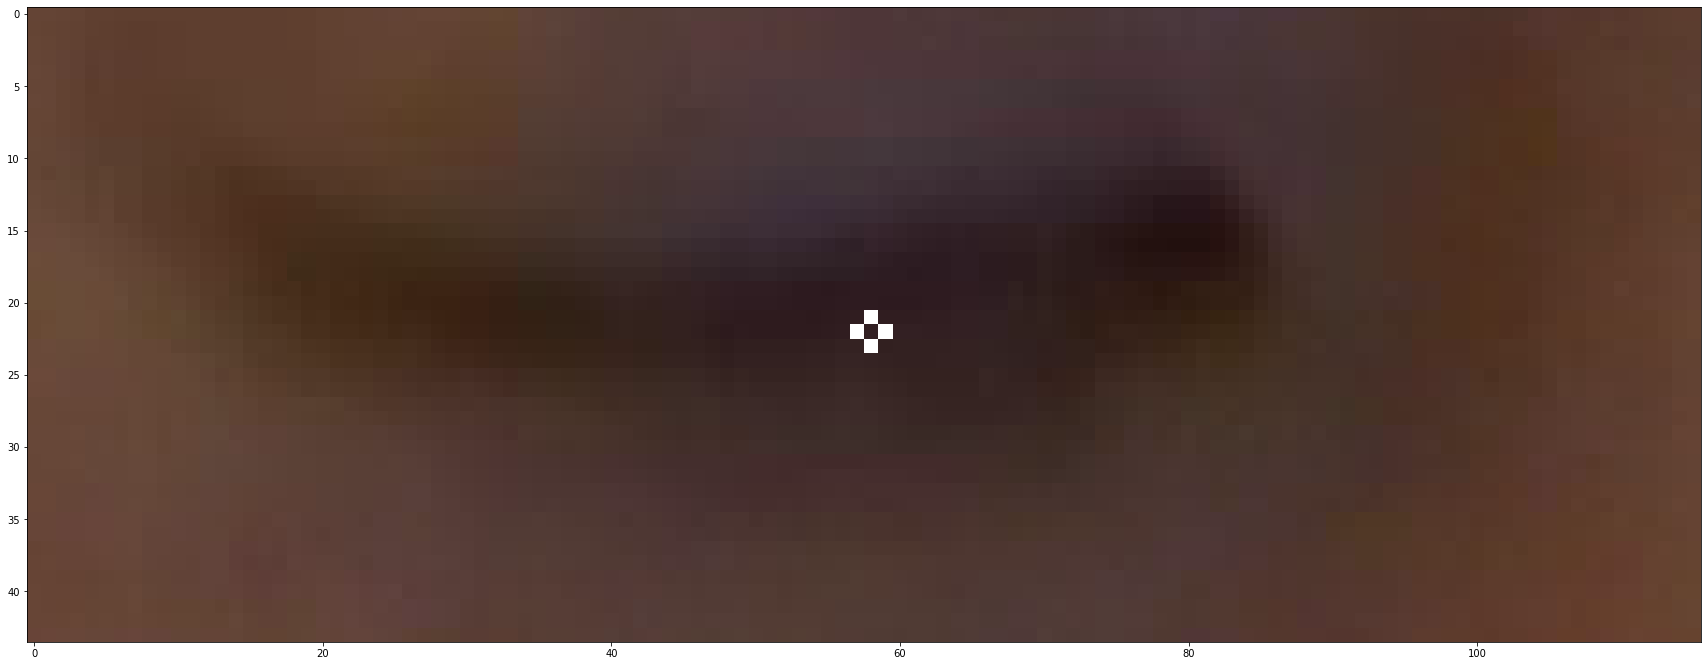

In [5]:
x = 17
print(f"radius[{x}]:{radius[x]} , ratio[{x}]:{ratio[x]}")
print(f"追跡元画像サイズ：{img[x].shape}")
print(f"虹彩周辺画像サイズ：{img_2[x].shape}")
plt.figure(figsize=(30,20))
plt.imshow(img_2[x])

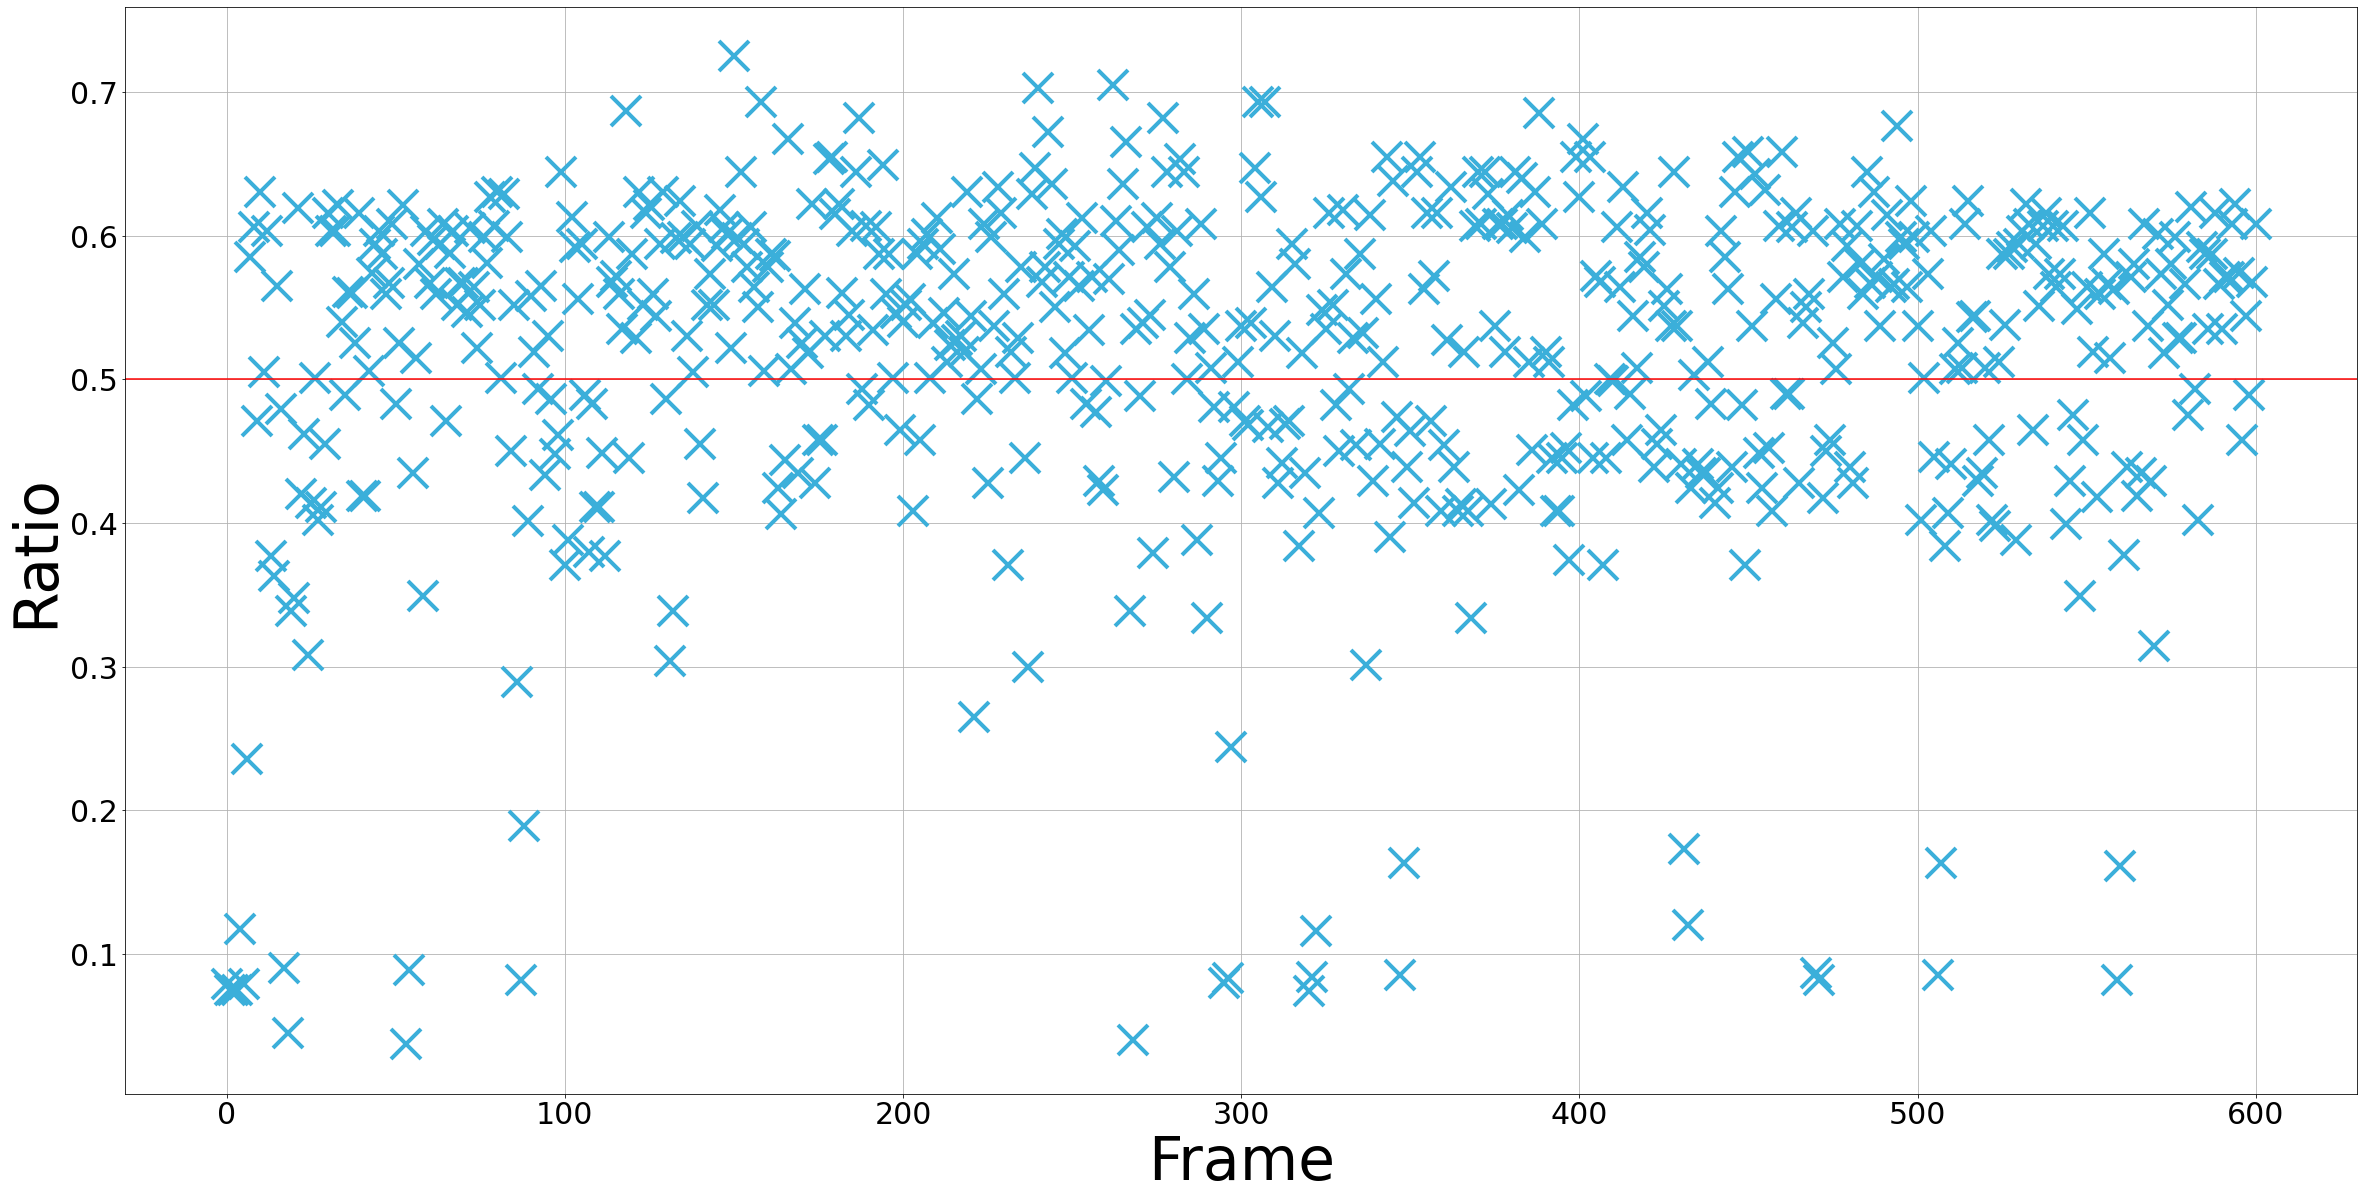

In [6]:
import pandas as pd

num = len(img)#開眼度のグラフを表示
x_1 = np.arange(num)
y_1 = np.array(ratio)
threshold = 0.5
z = (y_1<threshold)
#z = (y_1>threshold)
x_2 = np.where(z)#threshold未満を満たすインデックス
#print(x_2)

fig = plt.figure(figsize=(40,20))
#plt.plot(x_1,y_1) 
plt.plot(x_1,y_1,color="#3bafda",marker="x",markersize=30,markeredgewidth=4,linewidth=3,linestyle="None") 

plt.xlabel("Frame" ,fontsize = 60)
plt.ylabel("Ratio" ,fontsize = 60)
plt.tick_params(labelsize=30)
plt.grid()

plt.axhline(y=threshold,color='r')
plt.show()

In [7]:
print(len(x_2[0]))
print(x_2[0])

208
[  0   1   2   3   4   5   6   9  13  14  16  17  18  19  20  22  23  24
  25  27  28  29  35  40  41  50  53  54  55  58  65  84  86  87  88  89
  92  94  96  97  98 100 101 106 107 108 109 110 111 112 119 130 131 132
 140 141 163 164 165 169 174 175 176 188 190 199 203 205 221 222 225 231
 236 237 254 257 258 259 260 267 268 270 274 280 287 290 292 293 294 295
 296 297 298 301 302 308 311 312 313 314 317 319 320 321 322 323 328 329
 332 334 337 339 341 344 346 347 348 349 350 351 356 359 360 363 364 365
 367 368 374 382 386 392 393 394 395 396 397 398 402 404 407 408 410 414
 415 422 423 424 430 431 432 433 435 436 437 439 440 441 445 448 449 453
 454 456 457 461 462 465 470 471 472 473 474 480 481 501 505 506 507 508
 509 510 518 519 521 522 523 529 534 544 545 546 548 549 553 559 560 561
 562 565 566 569 570 580 582 583 596 598]


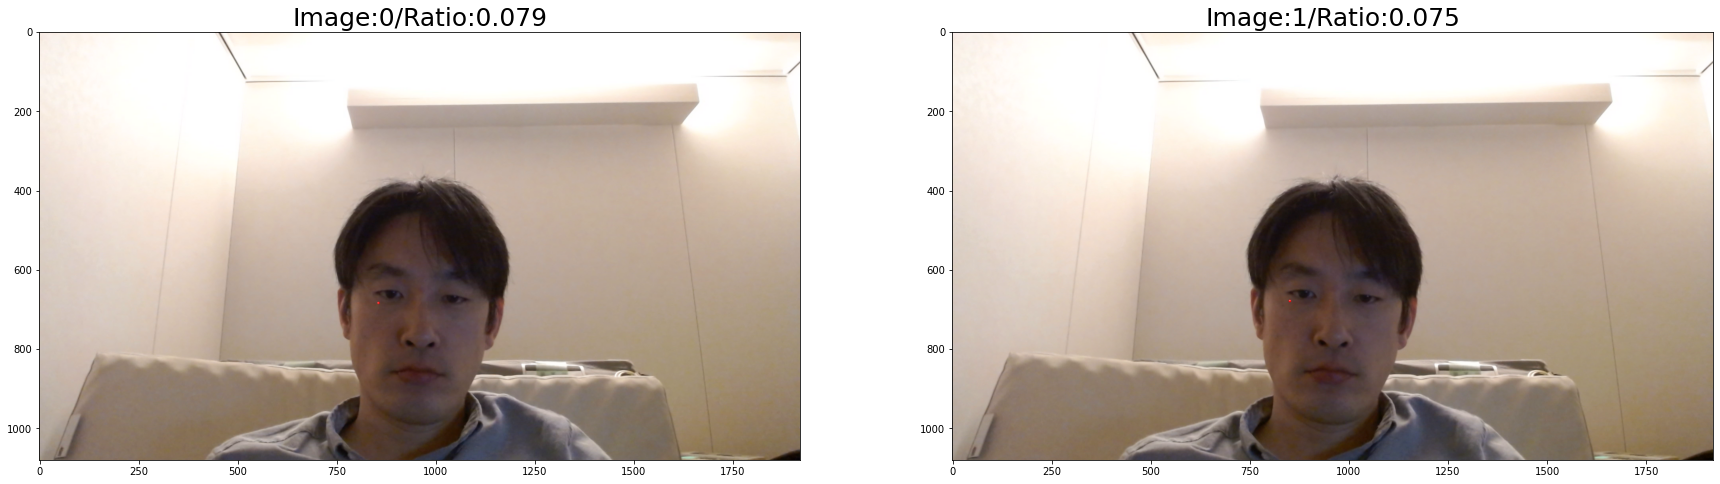

In [8]:
#開眼度の低い全体画像
num = len(x_2[0])
x=0
width = 2
# height = int(num/width)
height = 1
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x_2[0][x])+"/Ratio:"+str(ratio[x_2[0][x]]),fontsize=25)
        plt.imshow(img[x_2[0][x]])
        x+=1

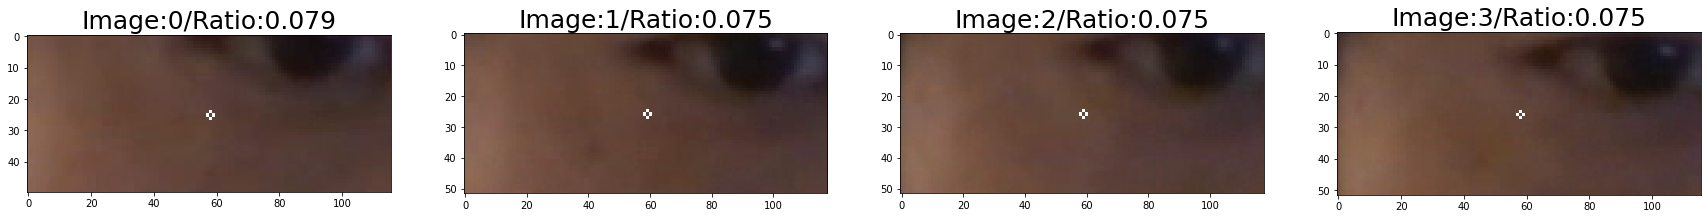

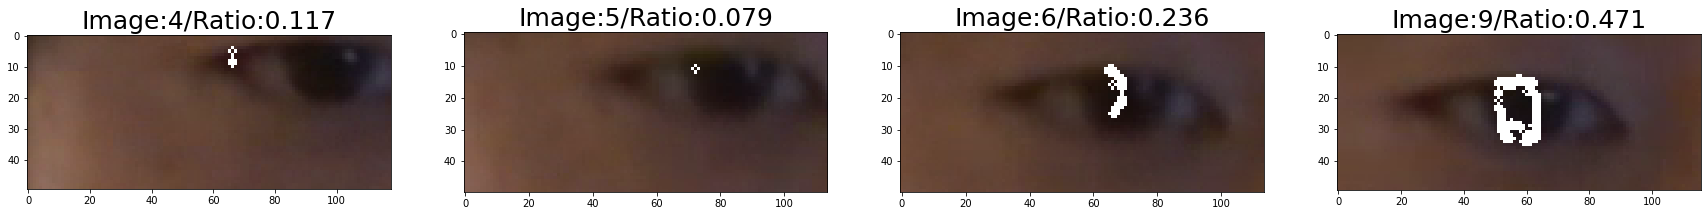

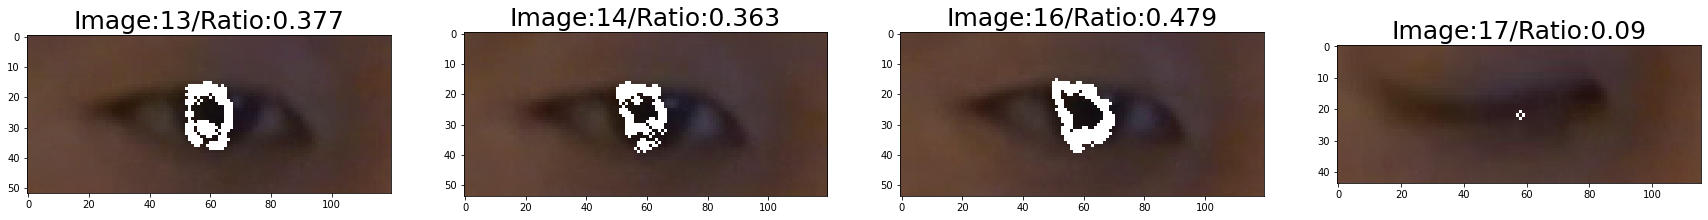

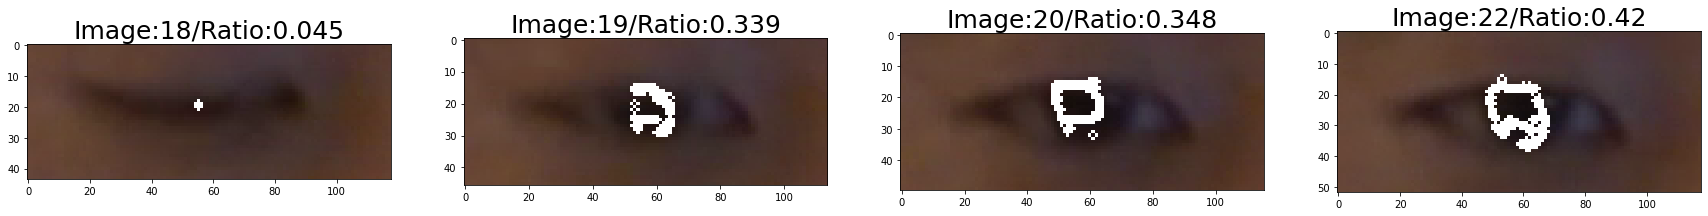

In [9]:
#開眼度の低い虹彩付近画像
num = len(x_2[0])
x=0
width = 4
# height = int(num/width)
height = 4
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x_2[0][x])+"/Ratio:"+str(ratio[x_2[0][x]]),fontsize=25)
        plt.imshow(img_2[x_2[0][x]])
        x+=1

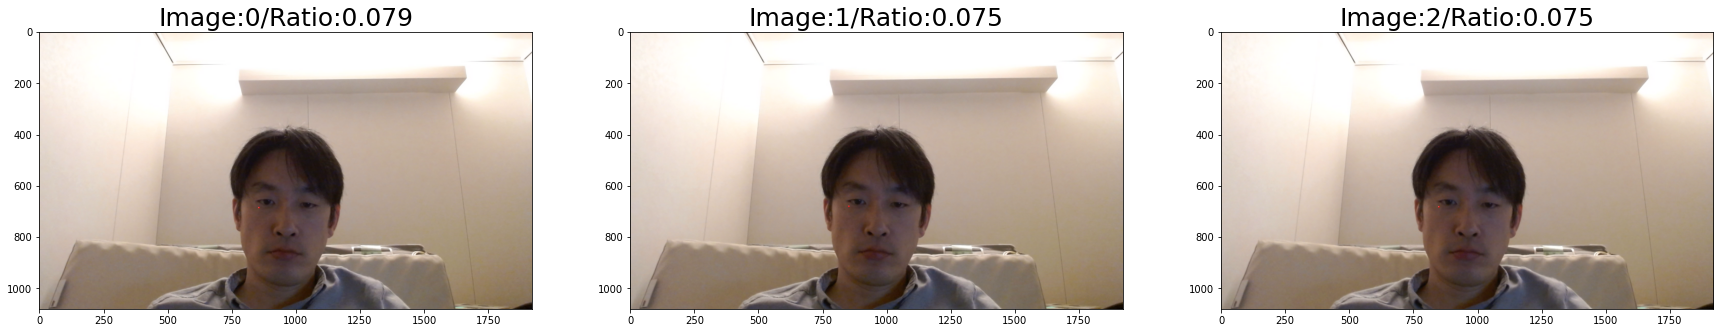

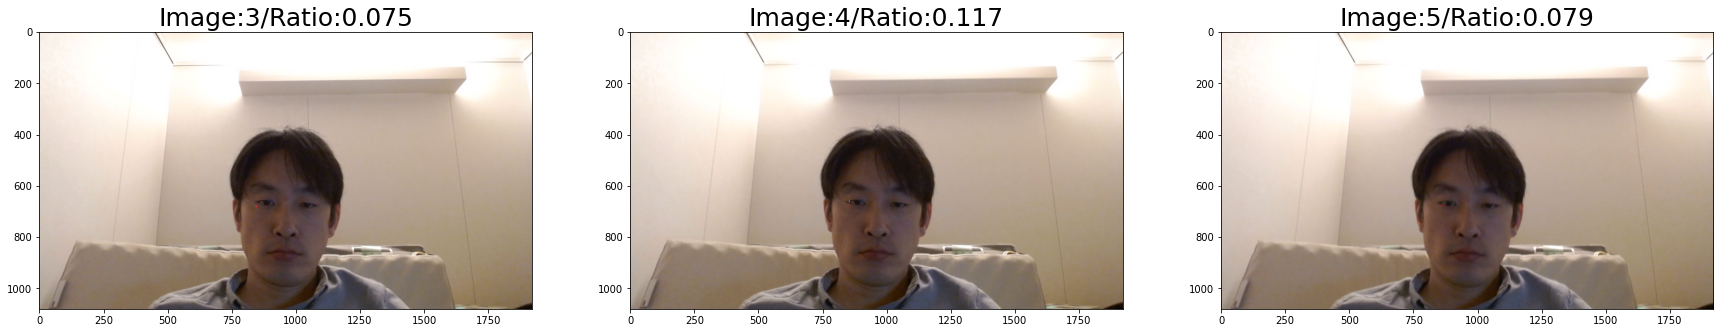

In [10]:
## 画像の表示
num = len(img)#画像と開眼度を表示
x= 0
width = 3
height = 2
for m in range(height):
    plt.figure(figsize=(30,20))
    for n in range(width):
        index=n%width+1
        index_2 = x
        plt.subplot(1,width,index)
        plt.title("Image:"+str(x)+"/Ratio:"+str(ratio[x]),fontsize=25)
        plt.imshow(img[index_2])
        x+=1

In [22]:
#    ここから保存！！！     #

In [11]:
name = "Dim_60cm"
method = "External"

In [12]:
#グラフ保存
fig.savefig("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Figure/" + method + ".png")
#リスト保存
import pickle
f = open("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Ratio/" + method + ".txt", 'wb')
list_row = ratio
pickle.dump(list_row, f)

In [13]:
#虹彩画像保存
for i in range(len(img)):
    iris = cv.cvtColor(img_2[i], cv.COLOR_BGR2RGB)
    cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Iris/"+str(i)+".png", iris)
    cv.imwrite("/work/Particle_Filter/Experiment/" + name + "/" + method + "/Origin/"+str(i)+".png",origin[i])

In [14]:
#動画保存
import os
import cv2 as cv
import numpy as np
num = len(img)#フィルタの数
x=0
# 画像サイズ
h = img[0].shape[0]
w = img[0].shape[1]
img_outdir = "/work/Particle_Filter/Experiment/Video/" + method +"/"
os.makedirs(img_outdir, exist_ok=True)
# 動画用の画像
outimg_files = img
# 動画作成
fourcc = cv.VideoWriter_fourcc(*'XVID')
video  = cv.VideoWriter(img_outdir + name + '_0.avi', fourcc, 20.0, (w, h), True)
for x in range(num):
    img_video = outimg_files[x]
    img_video = cv.cvtColor(img_video, cv.COLOR_BGR2RGB)
    video.write(img_video)
video.release()